In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# data is large, disable max row error
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

The following data set is the a time series of confirmed COVID-19 cases across the globe as of 27 March 2020.

The data was downloaded from the [COVID-19 Dashboards project](https://github.com/github/covid19-dashboard). This project uses Python and Altair to create a variety of visualizations related to the pandemic.

We will be working on visualizing different countries trajectories.

In [3]:
data = pd.read_csv('data/covid19_confirmed_global_2020-03-27.csv')

In [4]:
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


1- convert the data from a wide to a long format,
instead of having a column per date, create two columns
`Date`, and `Cases`. Populate `Date` with the column name and `Cases` with the value aassociated with the column

In [5]:
part1 = data.iloc[:, :4]
part1.head()

,Province/State,Country/Region,Lat,Long
0,NaN,Afghanistan,33.0000,65.0000
1,NaN,Albania,41.1533,20.1683
2,NaN,Algeria,28.0339,1.6596
3,NaN,Andorra,42.5063,1.5218
4,NaN,Angola,-11.2027,17.8739


In [6]:
part2 = data.iloc[:, 4:]
part2.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,0,0,0,0,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,0,0,0,0,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,0,0,0,0,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,0,0,0,0,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


### using data transformation operations 

In [7]:
df = part2.stack().reset_index()
df.columns = ['index', 'Date', 'Cases']
df = df.set_index('index')
df.head()

,Date,Cases
index,,
0,1/22/20,0
0,1/23/20,0
0,1/24/20,0
0,1/25/20,0
0,1/26/20,0


In [8]:
covid = part1.join(df)
covid.head()

,Province/State,Country/Region,Lat,Long,Date,Cases
0,NaN,Afghanistan,33.0,65.0,1/22/20,0
0,NaN,Afghanistan,33.0,65.0,1/23/20,0
0,NaN,Afghanistan,33.0,65.0,1/24/20,0
0,NaN,Afghanistan,33.0,65.0,1/25/20,0
0,NaN,Afghanistan,33.0,65.0,1/26/20,0


### using built-in function melt

In [9]:
covid = data.melt(id_vars=part1.columns, value_vars=part2.columns)
covid = covid.rename({'variable':'Date', 'value':'Cases'}, axis=1)
covid.head()

,Province/State,Country/Region,Lat,Long,Date,Cases
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0


In [10]:
covid['Date'] = pd.to_datetime(covid['Date'])
covid.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Cases                      int64
dtype: object

2- some countries have granular state/province-level data. 
Calculate total cases per country

In [11]:
country = covid.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()
country.head()

,Country/Region,Date,Cases
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0
3,Afghanistan,2020-01-25,0
4,Afghanistan,2020-01-26,0


3- Using line mark, create a timeline of  cases per countries.

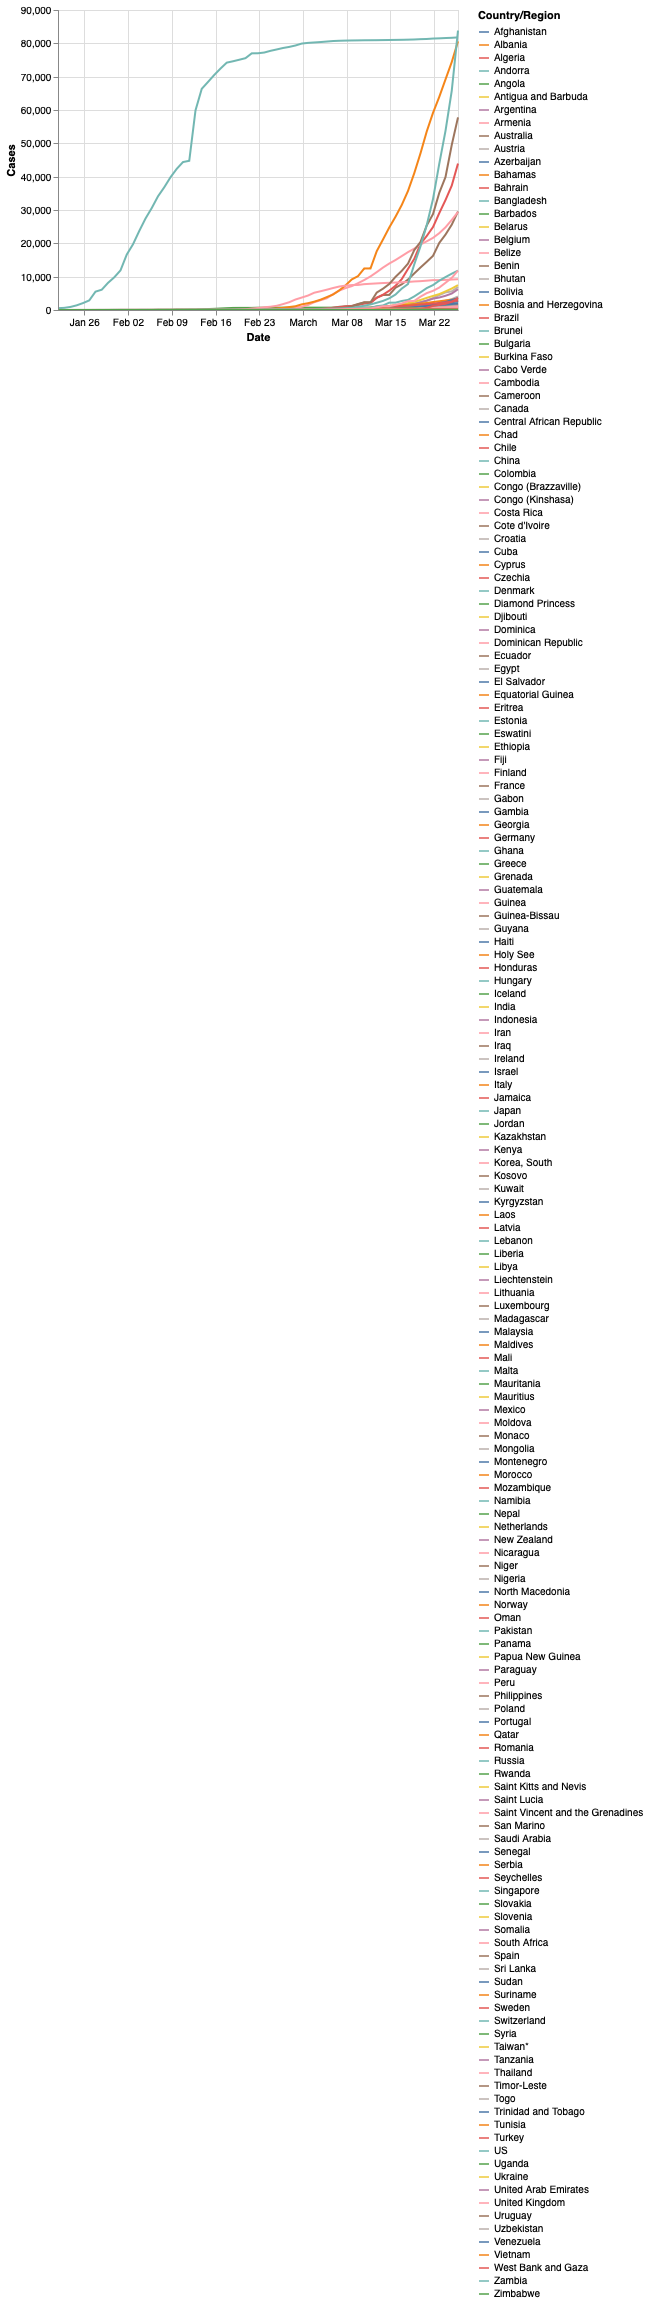

In [12]:
alt.Chart(country).mark_line().encode(
    x = 'Date',
    y = 'Cases',
    color='Country/Region',
    tooltip='Country/Region'
)

4- This figure is very busy, plot only the top five countries in terms of total cases

In [13]:
last_date = country.Date.sort_values().iloc[-1]
top_five = country[country.Date == last_date].sort_values('Cases', ascending=False
                )['Country/Region'].head().to_list()

In [14]:
top_five

['US', 'China', 'Italy', 'Spain', 'Germany']

In [15]:
#country[country['Country/Region'].apply(lambda x: x in top_five)]
top_five_data = country[country['Country/Region'].isin(top_five)]

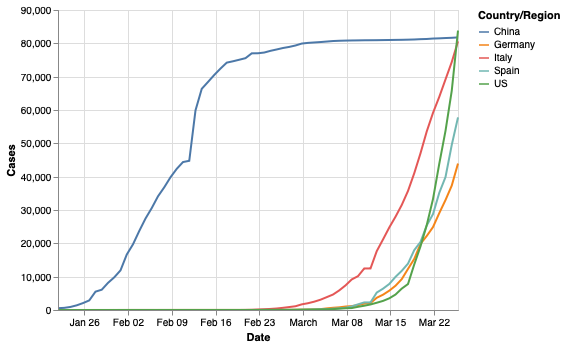

In [16]:
alt.Chart(top_five_data).mark_line().encode(
    x = 'Date',
    y = 'Cases',
    color='Country/Region',
    tooltip='Country/Region'
)

5- Create a similar chart for the China, plot each province in a separate line

In [17]:
china_data = covid[covid['Country/Region']=='China']

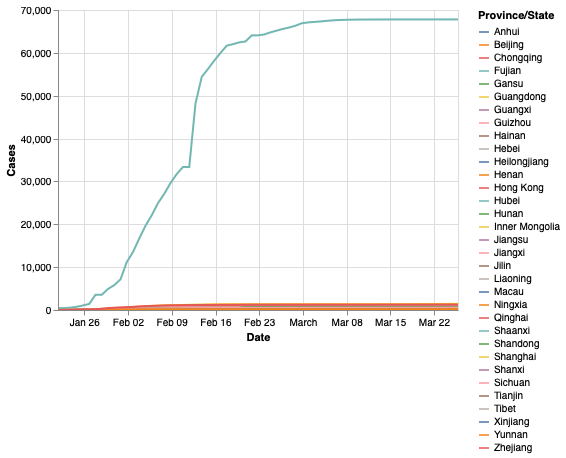

In [18]:
alt.Chart(china_data).mark_line().encode(
    x = 'Date',
    y = 'Cases',
    color='Province/State',
    tooltip='Province/State'
)